In [82]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Importing Libraries & HealthCheck

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [84]:
products = pd.read_csv('/content/gdrive/MyDrive/Colab Data/sample30.csv')

In [85]:
products.shape

(30000, 15)

In [86]:
products.head()


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [87]:
def checkNull(df):
    null_count = df.isnull().sum().sort_values(ascending = False)
    null_count_percentage = (df.isnull().sum()/len(df)*100).sort_values(ascending = False)
    final = pd.concat([null_count,null_count_percentage], axis = 1, keys = ['Count', 'Percentage_of_count'])
    return final[final['Count']>0]

In [88]:
checkNull(products)

,Count,Percentage_of_count
reviews_userProvince,29830,99.433333
reviews_userCity,28071,93.570000
reviews_didPurchase,14068,46.893333
reviews_doRecommend,2570,8.566667
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


### Task #1 - Data Cleaning

In [89]:
#Dropping all the columns with more than 40% missing data
products.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'],inplace=True)

In [90]:
##Renaming the columns
products.rename(columns = {'id' : 'productId'},inplace=True)
products.rename(columns = {'reviews_username' : 'userId'},inplace=True)
products.rename(columns = {'reviews_rating' : 'rating'},inplace=True)

In [91]:
#Drop the rows which do not have values for username as username is one of the unique fields
products = products[~(products['userId'].isnull())]
products.userId.value_counts()

byamazon customer    41
mike                 41
chris                32
lisa                 16
rick                 15
                     ..
gradgal               1
sue44                 1
amanda78              1
pechang               1
customer1234          1
Name: userId, Length: 24914, dtype: int64

In [92]:
# the value byamazon customer seams to be a placeholder default and should be removed
products = products[~(products['userId']=='byamazon customer')]

In [93]:
# Since the username is a unique value as claimed, we will just check the same,
# by checking the reviews give by different customers on the same product
products['combine'] = products['productId']+products['userId']
products['combine'].value_counts()

AVpfPaoqLJeJML435Xk9mike                15
AVpfPaoqLJeJML435Xk9chris                9
AVpfPaoqLJeJML435Xk9movielover           7
AVpfPaoqLJeJML435Xk9thomas               7
AVpfPaoqLJeJML435Xk9matt                 6
                                        ..
AVpfPaoqLJeJML435Xk9jcjimmy              1
AVpfJP1C1cnluZ0-e3Xysmith2127            1
AVpfJP1C1cnluZ0-e3Xydel737               1
AVpf3VOfilAPnD_xjpunsamantha02           1
AVpf9pzn1cnluZ0-uNTMbyjohnnie walker     1
Name: combine, Length: 27586, dtype: int64

In [94]:
# We can see there are multiple mike,chris who have reviewed the same product, 
# which we would assume is the same customer and rated the product consistently
# So we keep the first of all the reviews and drop the duplicates
products.drop_duplicates(subset='combine',keep='first',inplace=True)
products.drop(['combine'],axis=1,inplace=True)

In [95]:
checkNull(products)

,Count,Percentage_of_count
reviews_doRecommend,1997,7.239179
reviews_title,185,0.670630
manufacturer,140,0.507504
reviews_date,40,0.145001


## Sentitment Analysis


### Task #2 -Text Processing

In [96]:
#Prepare the dataset for sentiment Analysis, which consists of reviews_title, reviews_text, user_sentiment
productSentiment  = products[['reviews_title', 'reviews_text', 'user_sentiment']]

In [97]:
productSentiment.head()

,reviews_title,reviews_text,user_sentiment
0,Just Awesome,i love this album. it's very good. more to the...,Positive
1,Good,Good flavor. This review was collected as part...,Positive
3,Disappointed,I read through the reviews on here before look...,Negative
4,Irritation,My husband bought this gel for us. The gel cau...,Negative
5,Not worth it,My boyfriend and I bought this to spice things...,Negative


In [98]:
def concatTitleText(title,text):
    if pd.isnull(title):
        return text
    else:
        return title + '. ' + text

In [99]:
productSentiment['review'] = productSentiment.apply(lambda x: concatTitleText(x['reviews_title'],x['reviews_text']),axis=1)
productSentiment.drop(['reviews_title','reviews_text'],axis=1,inplace=True)

In [100]:
productSentiment = productSentiment.reindex(columns=['review','user_sentiment']) 

In [101]:
import re
import string

def clean_text(text):
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and ( not w.isdigit() and len(w)>3) )]) 
    text3 = re.sub(r'[^\w\s]','',text2)
    return text3.lower()

In [102]:
productSentiment['review'] = productSentiment['review'].apply(clean_text)

In [103]:
productSentiment.head()

,review,user_sentiment
0,just awesome love this album very good more si...,Positive
1,good good flavor this review collected part pr...,Positive
3,disappointed read through reviews here before ...,Negative
4,irritation husband bought this caused irritati...,Negative
5,worth boyfriend bought this spice things bedro...,Negative


In [104]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [105]:
productSentiment['review']=productSentiment['review'].apply(remove_stopwords)

In [106]:
productSentiment.head()

,review,user_sentiment
0,awesome love album good side current sound hyp...,Positive
1,good good flavor review collected part promotion,Positive
3,disappointed read reviews looking buying coupl...,Negative
4,irritation husband bought caused irritation fe...,Negative
5,worth boyfriend bought spice things bedroom hi...,Negative


### Task #3 - Feature Extraction

#### Test Train split

In [107]:
products['reviews_text'].head()

0    i love this album. it's very good. more to the...
1    Good flavor. This review was collected as part...
3    I read through the reviews on here before look...
4    My husband bought this gel for us. The gel cau...
5    My boyfriend and I bought this to spice things...
Name: reviews_text, dtype: object

In [108]:
X = productSentiment['review']
productSentiment['user_sentiment'] = np.where((productSentiment['user_sentiment'] == 'Positive'), 1, 0)
y = productSentiment['user_sentiment']

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

text_list=X_train.tolist()
test_text_list=X_test.tolist()

#### Count Vectorizer

In [110]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english',max_features=5000)
vect.fit(text_list)
X_train_tf = vect.transform(text_list)
X_test_tf =vect.transform(test_text_list)

#### TF_IDF Vecotrizer

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_train = tfidfconverter.fit_transform(text_list).toarray()
X_test = tfidfconverter.transform(test_text_list).toarray()

### Task #4 - Model Building

#### Common Functions

In [112]:
def calcMetrics(confusion,metrics):
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives 
    metrics['Sensitivity'] = TP / float(TP+FN)
    metrics['Precision'] = TP / float(TP + FP)
    metrics['Specificity'] = TN / float(TN+FP)
    return metrics

In [113]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import confusion_matrix
def evaluate_model(X,y,model):
    metrics = dict()
    metrics['Accuracy'] = accuracy_score(y, model.predict(X))
    c_m =confusion_matrix(y, model.predict(X))
    return calcMetrics(c_m,metrics)

In [114]:
modelCompare = pd.DataFrame()

#### Task #3 Handling Class Imbalance

In [115]:
from collections import Counter

##### Using SMOTE on CountVectors

In [116]:
from imblearn.over_sampling import SMOTE
print('Before',Counter(y_train))
# oversampling the train dataset using SMOTE
smt = SMOTE()
X_train_tf_sm, y_train_tf_sm = smt.fit_resample(X_train_tf, y_train)
print('After',Counter(y_train_tf_sm))

Before Counter({1: 17174, 0: 2136})
After Counter({1: 17174, 0: 17174})


##### Using SMOTE on TF-IDFVectors

In [117]:
from imblearn.over_sampling import SMOTE
print('Before',Counter(y_train))
# oversampling the train dataset using SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

print('After',Counter(y_train_sm))

Before Counter({1: 17174, 0: 2136})
After Counter({1: 17174, 0: 17174})


#### Naive Base methods

##### Bernoulli NB first

In [118]:
from sklearn.naive_bayes import BernoulliNB
bnb1 = BernoulliNB()
bnb1.fit(X_train_tf,y_train)
print(evaluate_model(X_train_tf, y_train,bnb1))
print(evaluate_model(X_test_tf, y_test,bnb1))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test_tf, y_test,bnb1),name='Bernoulli NB TF Imbalance'))
modelCompare.tail(1)

{'Accuracy': 0.8887622993267736, 'Sensitivity': 0.9475952020496099, 'Precision': 0.9287752539664422, 'Specificity': 0.4157303370786517}
{'Accuracy': 0.8737312711454809, 'Sensitivity': 0.9471395570050278, 'Precision': 0.9139784946236559, 'Specificity': 0.2846237731733915}


,Accuracy,Precision,Sensitivity,Specificity
Bernoulli NB TF Imbalance,0.873731,0.913978,0.94714,0.284624


In [119]:
from sklearn.naive_bayes import BernoulliNB
bnb2 = BernoulliNB()
bnb2.fit(X_train_tf_sm,y_train_tf_sm)
print(evaluate_model(X_train_tf_sm, y_train_tf_sm,bnb2))
print(evaluate_model(X_test_tf, y_test,bnb2))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test_tf, y_test,bnb2),name='Bernoulli NB TF SMOTE'))
modelCompare.tail(1)

{'Accuracy': 0.8756550599743799, 'Sensitivity': 0.823337603353907, 'Precision': 0.9195551798140079, 'Specificity': 0.9279725165948527}
{'Accuracy': 0.7667955534074432, 'Sensitivity': 0.8119309688816415, 'Precision': 0.9162705106578746, 'Specificity': 0.40458015267175573}


,Accuracy,Precision,Sensitivity,Specificity
Bernoulli NB TF SMOTE,0.766796,0.916271,0.811931,0.40458


##### Multinomial NB

In [120]:
from sklearn.naive_bayes import MultinomialNB
mnb1 = MultinomialNB()
#fit on training data
mnb1.fit(X_train_tf, y_train)

print(evaluate_model(X_train_tf, y_train,mnb1))
print(evaluate_model(X_test_tf, y_test,mnb1))

modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test_tf, y_test,mnb1),name='Bernoulli MB TF Imbalance'))
modelCompare.tail(1)

{'Accuracy': 0.8907301916105644, 'Sensitivity': 0.9464888785373239, 'Precision': 0.9317322022240055, 'Specificity': 0.44241573033707865}
{'Accuracy': 0.874939584340261, 'Sensitivity': 0.9449653485527925, 'Precision': 0.9169303797468354, 'Specificity': 0.31297709923664124}


,Accuracy,Precision,Sensitivity,Specificity
Bernoulli MB TF Imbalance,0.87494,0.91693,0.944965,0.312977


In [121]:
from sklearn.naive_bayes import MultinomialNB
mnb2 = MultinomialNB()
#fit on training data
mnb2.fit(X_train_tf_sm, y_train_tf_sm)

print(evaluate_model(X_train_tf_sm, y_train_tf_sm,mnb2))
print(evaluate_model(X_test_tf, y_test,mnb2))

modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test_tf, y_test,mnb2),name='Bernoulli MB TF SMOTE'))
modelCompare.tail(1)

{'Accuracy': 0.8467741935483871, 'Sensitivity': 0.8574007220216606, 'Precision': 0.8395575574434119, 'Specificity': 0.8361476650751135}
{'Accuracy': 0.8135572740454325, 'Sensitivity': 0.8540562576437016, 'Precision': 0.9305596683446846, 'Specificity': 0.48854961832061067}


,Accuracy,Precision,Sensitivity,Specificity
Bernoulli MB TF SMOTE,0.813557,0.93056,0.854056,0.48855


In [122]:
from sklearn.naive_bayes import MultinomialNB
mnb3 = MultinomialNB()
#fit on training data
mnb3.fit(X_train, y_train)

print(evaluate_model(X_train, y_train,mnb3))
print(evaluate_model(X_test, y_test,mnb3))

modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,mnb3),name='Bernoulli MB TF-IDF Imbalance'))
modelCompare.tail(1)

{'Accuracy': 0.8958052822371828, 'Sensitivity': 0.9967974845696984, 'Precision': 0.897410358565737, 'Specificity': 0.08380149812734082}
{'Accuracy': 0.889681005316578, 'Sensitivity': 0.9963310232368529, 'Precision': 0.8921878802628377, 'Specificity': 0.03380588876772083}


,Accuracy,Precision,Sensitivity,Specificity
Bernoulli MB TF-IDF Imbalance,0.889681,0.892188,0.996331,0.033806


In [123]:
from sklearn.naive_bayes import MultinomialNB
mnb4 = MultinomialNB()
#fit on training data
mnb4.fit(X_train_sm, y_train_sm)

print(evaluate_model(X_train_sm, y_train_sm,mnb4))
print(evaluate_model(X_test, y_test,mnb4))

modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,mnb4),name='Bernoulli MB TF-IDF SMOTE'))
modelCompare.tail(1)

{'Accuracy': 0.8396122044951672, 'Sensitivity': 0.8579247700011645, 'Precision': 0.8276133235971466, 'Specificity': 0.8212996389891697}
{'Accuracy': 0.8125906234896085, 'Sensitivity': 0.8385650224215246, 'Precision': 0.9444444444444444, 'Specificity': 0.604143947655398}


,Accuracy,Precision,Sensitivity,Specificity
Bernoulli MB TF-IDF SMOTE,0.812591,0.944444,0.838565,0.604144


#### Logistic Regression

##### Logistic Regression with balanced class weights

In [124]:
from sklearn.linear_model import LogisticRegression
logreg1 = LogisticRegression(random_state=42, C = 3.5, class_weight= 'balanced')
logreg1.fit(X_train,y_train)
print(evaluate_model(X_train, y_train,logreg1))
print(evaluate_model(X_test, y_test,logreg1))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,logreg1),name='LR Class weight Balanced'))
modelCompare.tail(1)

{'Accuracy': 0.9108234075608493, 'Sensitivity': 0.9038663095376732, 'Precision': 0.9954469667820957, 'Specificity': 0.9667602996254682}
{'Accuracy': 0.8721604639922668, 'Sensitivity': 0.8831362956923495, 'Precision': 0.9704345229207108, 'Specificity': 0.7840785169029444}


,Accuracy,Precision,Sensitivity,Specificity
LR Class weight Balanced,0.87216,0.970435,0.883136,0.784079


In [125]:
logreg2 = LogisticRegression(random_state=42, C = 3.5)
logreg2.fit(X_train_sm,y_train_sm)
print(evaluate_model(X_train_sm, y_train_sm,logreg2))
print(evaluate_model(X_test, y_test,logreg2))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,logreg2),name='LR SMOTE'))
modelCompare.tail(1)

{'Accuracy': 0.9569407243507628, 'Sensitivity': 0.9425876324676837, 'Precision': 0.9704454169414304, 'Specificity': 0.9712938162338418}
{'Accuracy': 0.8908893185113581, 'Sensitivity': 0.9152058703628211, 'Precision': 0.9602224123182207, 'Specificity': 0.6957470010905126}


,Accuracy,Precision,Sensitivity,Specificity
LR SMOTE,0.890889,0.960222,0.915206,0.695747


#### Classification Models

In [126]:
from sklearn.model_selection import GridSearchCV

##### Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=10,
                       min_samples_leaf=5, n_estimators=50, n_jobs=-1,
                       random_state=42)
rf1.fit(X_train, y_train)
print(evaluate_model(X_train, y_train,rf1))
print(evaluate_model(X_test,y_test,rf1))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,rf1),name='RF Balanced No Tuning'))
modelCompare.tail(1)

{'Accuracy': 0.6954945624029001, 'Sensitivity': 0.687434494002562, 'Precision': 0.9584348108459165, 'Specificity': 0.7602996254681648}
{'Accuracy': 0.6806428226196231, 'Sensitivity': 0.6793042532952847, 'Precision': 0.9464218099204846, 'Specificity': 0.6913849509269356}


,Accuracy,Precision,Sensitivity,Specificity
RF Balanced No Tuning,0.680643,0.946422,0.679304,0.691385


In [128]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(max_depth=4, max_features=10,
                       min_samples_leaf=5, n_estimators=50, n_jobs=-1,
                       random_state=42)
rf2.fit(X_train_sm, y_train_sm)
print(evaluate_model(X_train_sm, y_train_sm,rf2))
print(evaluate_model(X_test,y_test,rf2))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,rf2),name='RF SMOTE No Tuning'))
modelCompare.tail(1)

{'Accuracy': 0.7708745778502387, 'Sensitivity': 0.7334924886456271, 'Precision': 0.7927627438640654, 'Specificity': 0.8082566670548503}
{'Accuracy': 0.7102464958917352, 'Sensitivity': 0.7252344068487566, 'Precision': 0.9341851916681253, 'Specificity': 0.5899672846237731}


,Accuracy,Precision,Sensitivity,Specificity
RF SMOTE No Tuning,0.710246,0.934185,0.725234,0.589967


In [129]:
%%time
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1,class_weight="balanced")
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [4,5,10,15],
    'min_samples_leaf': [5, 10, 20],
    'max_features': [10,20],
    'n_estimators': [30, 50,60]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1,scoring = "recall")
grid_search.fit(X_train,y_train)
rf3 = grid_search.best_estimator_
print(evaluate_model(X_train, y_train,rf3))
print(evaluate_model(X_test, y_test,rf3))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,rf3),name='RF Best Balanced'))
modelCompare.tail(1)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  5.3min finished


{'Accuracy': 0.8034697048161574, 'Sensitivity': 0.8005124024688482, 'Precision': 0.9738613019763406, 'Specificity': 0.827247191011236}
{'Accuracy': 0.7850410826486225, 'Sensitivity': 0.7933143090093763, 'Precision': 0.9576771653543307, 'Specificity': 0.7186477644492911}
CPU times: user 12.7 s, sys: 947 ms, total: 13.7 s
Wall time: 5min 25s


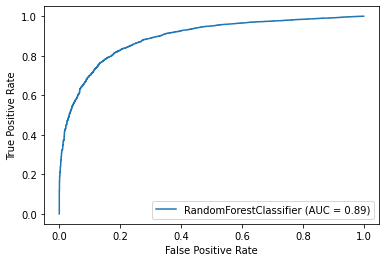

In [130]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf3, X_train, y_train)

In [131]:
%%time
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [4,5,10,15],
    'min_samples_leaf': [5, 10, 20],
    'max_features': [10,20],
    'n_estimators': [30, 50,60]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1,scoring = "recall")
grid_search.fit(X_train_sm,y_train_sm)
rf4 = grid_search.best_estimator_
print(evaluate_model(X_train_sm, y_train_sm,rf4))
print(evaluate_model(X_test, y_test,rf4))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,rf4),name='RF Best SMOTE'))
modelCompare.tail(1)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  9.5min finished


{'Accuracy': 0.8169616862699429, 'Sensitivity': 0.7966693839524863, 'Precision': 0.8303696061176185, 'Specificity': 0.8372539885873995}
{'Accuracy': 0.7672788786853553, 'Sensitivity': 0.7874711237939938, 'Precision': 0.9412051323696605, 'Specificity': 0.6052344601962922}
CPU times: user 19.4 s, sys: 1.55 s, total: 20.9 s
Wall time: 9min 40s


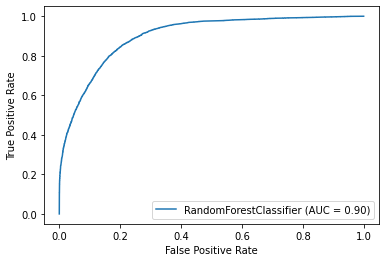

In [132]:
plot_roc_curve(rf4, X_train_sm, y_train_sm)

##### XGBoost

In [ ]:
#xgboost using default parameters
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score
xgclf1 = xgb.XGBClassifier()
xgclf1.fit(X_train, y_train)
y_train_pred_prob=xgclf1.predict_proba(X_train)[:, 1]
y_test_pred_prob=xgclf1.predict_proba(X_test)[:, 1]
print('AUC on train data by XGBoost =', roc_auc_score(y_true=y_train,y_score=y_train_pred_prob))
print('AUC on test data by XGBoost =', roc_auc_score(y_true=y_test,y_score=y_test_pred_prob))
print(evaluate_model(X_train, y_train,xgclf1))
print(evaluate_model(X_test, y_test,xgclf1))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,xgclf1),name='XG Boost No Tuning Imbalanced'))
modelCompare.tail(1)

AUC on train data by XGBoost = 0.8934641997593262
AUC on test data by XGBoost = 0.8731894253922118
{'Accuracy': 0.8970481615743138, 'Sensitivity': 0.9990683591475487, 'Precision': 0.8969158389963409, 'Specificity': 0.07677902621722846}
{'Accuracy': 0.8935476075398744, 'Sensitivity': 0.9979616795760293, 'Precision': 0.8945188794153471, 'Specificity': 0.05561613958560523}


,Accuracy,Precision,Sensitivity,Specificity
XG Boost No Tuning Imbalanced,0.893548,0.894519,0.997962,0.055616


In [ ]:
#xgboost using default parameters
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score
xgclf2 = xgb.XGBClassifier()
xgclf2.fit(X_train_sm, y_train_sm)
y_train_pred_prob=xgclf2.predict_proba(X_train_sm)[:, 1]
y_test_pred_prob=xgclf2.predict_proba(X_test)[:, 1]
print('AUC on train data by XGBoost =', roc_auc_score(y_true=y_train_sm,y_score=y_train_pred_prob))
print('AUC on test data by XGBoost =', roc_auc_score(y_true=y_test,y_score=y_test_pred_prob))
print(evaluate_model(X_train_sm, y_train_sm,xgclf2))
print(evaluate_model(X_test, y_test,xgclf2))
modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,xgclf2),name='XG Boost No Tuning SMOTE'))
modelCompare.tail(1)

AUC on train data by XGBoost = 0.9282462681441009
AUC on test data by XGBoost = 0.866838475368924
{'Accuracy': 0.8371375334808432, 'Sensitivity': 0.8261907534645394, 'Precision': 0.8446838909393976, 'Specificity': 0.8480843134971469}
{'Accuracy': 0.805461575640406, 'Sensitivity': 0.8198124745209947, 'Precision': 0.9550419502928605, 'Specificity': 0.6902944383860414}


,Accuracy,Precision,Sensitivity,Specificity
XG Boost No Tuning SMOTE,0.805462,0.955042,0.819812,0.690294


In [ ]:
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score


In [ ]:
#xgboost using hyper parameter tuning

xgb_model = xgb.XGBClassifier(n_jobs=-1,
                              random_state=42,
                              use_label_encoder=False,
                              objective = "binary:logistic",
                              nthread = -1,
                              eval_metric='auc')
parameters = {'learning_rate': [0.2,0.3],
              'max_depth': [2,4,],
              'min_child_weight': [1,10],
              'n_estimators': [50, 100]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

clf_xgb = GridSearchCV(estimator=xgb_model,
                                       param_grid=parameters,
                                       n_jobs=-1,
                                       cv=3,
                                       scoring=scorer,
                                       refit=True)


In [133]:
# clf_xgb.fit(X_train_sm, y_train_sm)

In [ ]:
# xgclf3 = xgb.XGBClassifier()
# xgclf3.fit(X_train_sm, y_train_sm)
# y_train_pred_prob=final_model.predict_proba(X_train_sm)[:, 1]
# y_test_pred_prob=final_model.predict_proba(X_test)[:, 1]
# print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train_sm,y_score=y_train_pred_prob))
# print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,y_score=y_test_pred_prob))
# print(evaluate_model(X_train_sm, y_train_sm,xgclf3))
# print(evaluate_model(X_test, y_test,xgclf3))
# modelCompare = modelCompare.append(pd.Series(evaluate_model(X_test, y_test,clf_xgb_best),name='XG Boost Best SMOTE'))
# modelCompare.tail(1)

#### Model Comparision

In [ ]:
modelCompare

,Accuracy,Precision,Sensitivity,Specificity
Bernoulli NB TF Imbalance,0.873731,0.913978,0.947140,0.284624
Bernoulli NB TF SMOTE,0.767400,0.916974,0.811931,0.410033
Bernoulli MB TF Imbalance,0.874940,0.916930,0.944965,0.312977
Bernoulli MB TF SMOTE,0.816216,0.931167,0.856638,0.491821
Bernoulli MB TF-IDF Imbalance,0.889681,0.892188,0.996331,0.033806
Bernoulli MB TF-IDF SMOTE,0.815732,0.945208,0.841555,0.608506
LR Class weight Balanced,0.872160,0.970435,0.883136,0.784079
LR SMOTE,0.891977,0.961324,0.915342,0.704471
RF Balanced No Tuning,0.680643,0.946422,0.679304,0.691385
RF SMOTE No Tuning,0.715442,0.933172,0.732436,0.579062


####Plotting the ROC Curve

#### Finding Optimal Cutoff Point

#### Pickling the Best Model

In [ ]:
# import pickle
# pickle.dump(logreg1,open('/content/gdrive/MyDrive/Colab Data/logreg_scenario_1.pkl','wb'))

In [ ]:
# products_all = pd.read_csv('/content/gdrive/MyDrive/Colab Data/sample30.csv')
# X_transformed_LR_scenario_1=tfidfconverter.transform(products_all['reviews_text'].tolist())
# np.savez_compressed(open('/content/gdrive/MyDrive/Colab Data/X_transformed_LR_scenario_1.npz','wb'),X_transformed_LR_scenario_1)

## Task #5 - Recommendation Engine

#### Create a Product Name/Category - Product Id Mapping

In [134]:
productMapping = products.drop_duplicates(subset='productId',keep='first')[['productId','name','categories']]

In [135]:
productMapping.shape

(271, 3)

In [136]:
productMapping.head()

,productId,name,categories
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo..."
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co..."
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm..."
30,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream","Personal Care,Skin Care,Hand Cream,Beauty,Body..."
36,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar,"Personal Care,Bath, Shower & Soap,Featured Bra..."


#### Preparing dataset for recommendation engine

In [137]:
ratings = products[['userId','productId','rating']]

In [138]:
ratings.head()

,userId,productId,rating
0,joshua,AV13O1A8GV-KLJ3akUyj,5
1,dorothy w,AV14LG0R-jtxr-f38QfS,5
3,rebecca,AV16khLE-jtxr-f38VFn,1
4,walker557,AV16khLE-jtxr-f38VFn,1
5,samantha,AV16khLE-jtxr-f38VFn,1


In [139]:
# Test and Train split of the dataset.
train, test = train_test_split(ratings, test_size=0.30, random_state=31)

In [140]:
print(train.shape)
print(test.shape)

(19310, 3)
(8276, 3)


In [141]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot_user = train.pivot(
    index='userId',
    columns='productId',
    values='rating'
).fillna(0)

df_pivot_user.head(3)

productId,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,...,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [142]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [143]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [144]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='userId',
    columns='productId',
    values='rating'
).fillna(1)

In [145]:
dummy_train.head()

productId,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,...,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.



#### Using Cosine Similarity on User-user

In [146]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot_user, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


In [147]:
user_correlation.shape

(17853, 17853)

##### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [148]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [149]:
user_predicted_ratings = np.dot(user_correlation, df_pivot_user.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.98058068, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.00767062, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.53553391],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.57353933],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.53553391]])

In [150]:
user_predicted_ratings.shape

(17853, 254)

In [151]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head(10)

productId,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,...,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,1.662975,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.662975,0.0,0.0,0.000000,...,0.000000,0.0,3.123475,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.332595,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
00sab00,0.0,0.0,0.980581,5.655628,0.0,0.0,0.0,0.000000,1.636634,1.290994,0.0,0.0,0.0,0.0,0.000000,0.901263,0.901263,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.886751,0.0,0.0,5.386751,0.0,0.0,0.0,0.000000,0.0,0.0,1.684304,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.332595,3.703774,0.0,0.0,0.610847,0.0,0.0,0.000000,5.196152,5.277337,0.000000,1.217161,0.0,0.0,1.500000,2.684304,0.0,0.0,0.000000,0.0,0.0,2.620712,1.164226,0.0,0.0,0.000000
02dakota,0.0,0.0,3.007671,9.020571,0.0,0.0,0.0,0.000000,2.121320,0.000000,0.0,0.0,0.0,0.0,2.443389,0.901263,0.901263,3.535534,3.123475,0.000000,0.0,3.123475,0.0,11.814773,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,20.415740,0.0,0.0,0.0,79.964290,0.0,0.0,2.105380,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,8.007885,0.0,0.0,3.612153,0.0,0.0,0.693375,4.503071,0.000000,3.086067,6.035534,0.0,0.0,1.500000,5.900543,0.0,0.0,1.952834,0.0,0.0,0.000000,1.552301,0.0,0.0,0.000000
02deuce,0.0,0.0,3.007671,9.020571,0.0,0.0,0.0,0.000000,2.121320,0.000000,0.0,0.0,0.0,0.0,2.443389,0.901263,0.901263,3.535534,3.123475,0.000000,0.0,3.123475,0.0,11.814773,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,20.415740,0.0,0.0,0.0,79.964290,0.0,0.0,2.105380,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,8.007885,0.0,0.0,3.612153,0.0,0.0,0.693375,4.503071,0.000000,3.086067,6.035534,0.0,0.0,1.500000,5.900543,0.0,0.0,1.952834,0.0,0.0,0.000000,1.552301,0.0,0.0,0.000000
0325home,0.0,0.0,0.000000,12.040385,0.0,0.0,0.0,3.535534,3.535534,4.387725,0.0,0.0,0.0,0.0,0.000000,1.502104,1.502104,0.000000,0.000000,0.980581,0.0,0.000000,0.0,9.

#### Item - Item Based

In [152]:
df_pivot_item = train.pivot(
    index='userId',
    columns='productId',
    values='rating'
).T

df_pivot_item.head()

userId,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,1143mom,1234,1234561,1234567,123cat123,123charlie,123numbers,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ram,13thfaerie,1421nikki,143st,1515,15425shopper,1753,17roses,18612,1863philly,1943,1950rmm,1970,1992firebirdgirl,19bubba67,19granny,...,ziana,zibber23,zibby4,ziggy,zillafan,zillanator,zink,zinnian,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmom,znxfyt,zod10,zoe1988,zoeellasca,zoey,zoeyny,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zoomin76,zotox,zout22389,zsarah,zsazsa,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
mean = np.nanmean(df_pivot_item, axis=1)
df_subtracted = (df_pivot_item.T-mean).T

In [154]:
df_subtracted.head()

userId,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,1143mom,1234,1234561,1234567,123cat123,123charlie,123numbers,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ram,13thfaerie,1421nikki,143st,1515,15425shopper,1753,17roses,18612,1863philly,1943,1950rmm,1970,1992firebirdgirl,19bubba67,19granny,...,ziana,zibber23,zibby4,ziggy,zillafan,zillanator,zink,zinnian,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmom,znxfyt,zod10,zoe1988,zoeellasca,zoey,zoeyny,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zoomin76,zotox,zout22389,zsarah,zsazsa,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.151376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Cosine Similarity on Item item based

In [155]:
from sklearn.metrics.pairwise import pairwise_distances

In [156]:
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [157]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [158]:
item_predicted_ratings = np.dot((df_pivot_item.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00268827],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00537654]])

In [159]:
item_predicted_ratings.shape

(17853, 254)

In [160]:
dummy_train.shape

(17853, 254)

In [161]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

productId,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,...,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.019286,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.017398,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
00sab00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004299,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.001029,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
02dakota,0.0,0.0,0.0,0.002323,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.014904,0.00000,0.00000,0.049048,0.0,0.0,0.0,0.002067,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.046459,0.0,0.0,0.013286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.018547,0.0,0.0,0.0,0.002243,0.000000,0.0,0.014514,0.0,0.0,0.0,0.000131,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
02deuce,0.0,0.0,0.0,0.001858,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.011923,0.00000,0.00000,0.039239,0.0,0.0,0.0,0.001653,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.037167,0.0,0.0,0.010628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.014837,0.0,0.0,0.0,0.001795,0.000000,0.0,0.011611,0.0,0.0,0.0,0.000104,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
0325home,0.0,0.0,0.0,0.000320,0.0,0.0,0.0,0.002367,0.001919,0.005714,0.0,0.0,0.0,0.0,0.000000,0.00401,0.00282,0.000000,0.0,0.0,0.0,0.000000,0.0,0.001783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001695,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00693,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.001530,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001369,0.0,0.0,0.006721


#### Compare User-user based to Item-Item based engine

In [ ]:
#Comparing RMSE values

### Recommendations

### Task 7: Fine-Tuning the Recommendation System.. From 20 Recommendation to Top 5

In [183]:
def getProductSentiment(model,X):
  pred=model.predict(X)
  prediction = model.predict_proba(X)
  df_final = pd.DataFrame()
  df_final['productId'] = products['productId']
  df_final['name'] = products['name']
  df_final['reviews_text'] = products['reviews_text']
  df_pred_prob = pd.DataFrame(prediction, columns=['Negative','Positive'])
  df_final['max_prob'] = df_pred_prob[['Negative','Positive']].max(axis=1)
  df_final['max_prob_class'] = df_pred_prob.idxmax(axis=1)
  df_final['Prediction'] = pred
  return df_final

In [181]:
def checkProductSentiment(productList,productsSentiments):
  productPercent = {}
  for id in productList:
    filteredProduct = productsSentiments[productsSentiments['productId']==id]
    percentPositive = filteredProduct['Prediction'].sum()/len(filteredProduct)
    productPercent[id]=percentPositive
  productPercentAsc =sorted(productPercent.items(), key=lambda x: x[1])
  finalprodList = [i [0] for i in productPercentAsc[::-1][:5]]
  return finalprodList

In [187]:
def getRecommendedProduct(username,productMapping,final_rating):
  X_transformed_LR_scenario_1=tfidfconverter.transform(products['reviews_text'].tolist())
  productsSentiments = getProductSentiment(logreg1, X_transformed_LR_scenario_1)
  df_final = final_rating.loc[username].sort_values(ascending=False)[0:20]
  df_final = pd.merge(df_final,productMapping,left_on='productId',right_on='productId',how = 'left')
  productList = list(df_final['productId'])
  final5 = checkProductSentiment(productList,productsSentiments)
  df_final5 = df_final[df_final['productId'].isin(final5)]
  print('Already Bought' + products[products['userId']==username]['name'].head())
  print('All 20 recommendation')
  print(df_final)
  print('Top 5')
  print(df_final5)
  

### Task #6: Recommendation of Top 20 Products to a Specified User

In [188]:
# User - user based recommendation
user_input = input("Enter your user name")
getRecommendedProduct(user_input,productMapping,user_final_rating)

Enter your user name02dakota
25656    Already BoughtGodzilla 3d Includes Digital Cop...
Name: name, dtype: object
All 20 recommendation
               productId  ...                                         categories
0   AVpfRTh1ilAPnD_xYic2  ...  Movies, Music & Books,Movies,Kids' & Family,Wa...
1   AVpe41TqilAPnD_xQH3d  ...  Movies & TV Shows,Movies,Romance,Romantic Come...
2   AVpf0eb2LJeJML43EVSt  ...  Movies, Music & Books,Ways To Shop Entertainme...
3   AVpe59io1cnluZ0-ZgDU  ...  Movies, Music & Books,Movies,Comedy,Movies & T...
4   AVpf2tw1ilAPnD_xjflC  ...  Movies & TV Shows,Instawatch Movies By VUDU,Sh...
5   AVpf3VOfilAPnD_xjpun  ...  Household Essentials,Cleaning Supplies,Kitchen...
6   AVpf0thK1cnluZ0-r8vR  ...  Movies, Music & Books,Movies,New Movie Release...
7   AVpfJP1C1cnluZ0-e3Xy  ...  Household Chemicals,Household Cleaners,Bath & ...
8   AVpfPnrU1cnluZ0-g9rL  ...  Movies, Music & Books,Movies,Sci-Fi & Fantasy,...
9   AVpfM_ytilAPnD_xXIJb  ...  Food,Packaged Foods,Sna

In [189]:
# Item - Item based recommendation
user_input = input("Enter your user name")
getRecommendedProduct(user_input,productMapping,item_final_rating)

Enter your user name02dakota
25656    Already BoughtGodzilla 3d Includes Digital Cop...
Name: name, dtype: object
All 20 recommendation
               productId  ...                                         categories
0   AVpf5olc1cnluZ0-tPrO  ...  Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...
1   AVpfE7puilAPnD_xUcCW  ...  Furniture,Bedroom Furniture,Nightstands,Home,H...
2   AVpfBU2S1cnluZ0-cJsO  ...  Food,Packaged Foods,Snacks,Energy Bars,Health,...
3   AVpfNc9cLJeJML434tza  ...  Home,Home Improvement,Light Bulbs,Electrical,A...
4   AVpf0thK1cnluZ0-r8vR  ...  Movies, Music & Books,Movies,New Movie Release...
5   AV1ZSp2uglJLPUi8IQFy  ...  Personal Care,Skin Care,Moisturizer,Beauty,Fac...
6   AVpe41TqilAPnD_xQH3d  ...  Movies & TV Shows,Movies,Romance,Romantic Come...
7   AVpf0pfrilAPnD_xi6s_  ...  Home,Home Decor,Home Accents,Artificial Flower...
8   AVpfR5m0LJeJML436K3W  ...  Music on CD or Vinyl,Country Music on CD or Vi...
9   AVpfnRuSilAPnD_xfB8l  ...  Personal Care,Bath, Sho

### Prepare final item-item recommendation

In [ ]:
# Save dataframe to pickled pandas object
# item_final_rating.to_pickle('/content/gdrive/MyDrive/Colab Data/item_final_rating')
# # Load dataframe from pickled pandas object
# df= pd.read_pickle(file_name)